In [29]:
import re
import time
import timeit

import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import ml
from sklearn.feature_extraction.text import CountVectorizer


In [30]:
cleaned_description = ml.get_and_clean_data()
cleaned_description = cleaned_description.apply(lambda s: re.sub(r'[^A-Za-z]', ' ', s))
cleaned_description = cleaned_description.apply(lambda s: re.sub(r'\s+', ' ', s))
tokenized_description = cleaned_description.apply(lambda s: word_tokenize(s))

concated = np.unique(np.concatenate([s for s in tokenized_description.values]))
stem_cache = {}
ps = PorterStemmer()
for s in concated:
    stem_cache[s] = ps.stem(s)

In [31]:
def setRemove(data):
    # print(len(data))
    tokenized_description = data 
    stop_set = set(stopwords.words())
    sw_removed_description = tokenized_description.apply(lambda s: set(s) - stop_set)
    sw_removed_description = sw_removed_description.apply(lambda s: {word for word in s if len(word) > 2})
    return sw_removed_description
    

In [32]:
size_list = [100, 500, 1000,2500,5000,10000]
set_time = []


for size in size_list:
    set_time.append(timeit.timeit(lambda: setRemove(tokenized_description[:size]), number=1 ))
set_time

[0.04703319992404431,
 0.12580890010576695,
 0.09291830006986856,
 0.19584539998322725,
 0.772392800077796,
 0.9149175999918953]

In [33]:
array_time = []
matmul_time = []
todok_time = []
tolil_time = []
tocoo_time = []
tocsc_time = []

for size in size_list:
    sw_removed_data = setRemove(tokenized_description[:size])
    stemmed_description = sw_removed_data.apply(lambda s: [stem_cache[w] for w in s])
    cv = CountVectorizer(analyzer=lambda x: x)
    X = cv.fit_transform(stemmed_description)
    XX = X.toarray()
    array_time.append(timeit.timeit(lambda: X * X.T, number=1))
    matmul_time.append(timeit.timeit(lambda: np.matmul(XX, XX.T), number=1))
    todok_time.append(timeit.timeit(lambda: X.todok() * X.T.todok(), number=3) / 3)
    tolil_time.append(timeit.timeit(lambda: X.tolil() * X.T.tolil(), number=3) / 3)
    tocoo_time.append(timeit.timeit(lambda: X.tocoo() * X.T.tocoo(), number=3) / 3)
    tocsc_time.append(timeit.timeit(lambda: X.tocsc() * X.T.tocsc(), number=3) / 3)


    

In [43]:
df = pd.DataFrame({'size': size_list, 'array': array_time, 'matmul': matmul_time, 'dok': todok_time, 'lil': tolil_time, 'coo': tocoo_time, 'csc': tocsc_time  })
df

,size,array,matmul,dok,lil,coo,csc
0,100,0.001617,0.027832,0.023566,0.006865,0.001512,0.001006
1,500,0.017585,1.270139,0.128567,0.044152,0.024637,0.025603
2,1000,0.081336,7.011351,0.282278,0.145367,0.096713,0.089112
3,2500,0.498114,75.501905,0.994190,0.518032,0.472895,0.483102
4,5000,1.856023,429.262717,3.018680,1.964006,1.906310,1.871231
5,10000,4.781847,1110.140499,6.552979,4.621389,4.528839,4.517727


<Axes: xlabel='size', ylabel='time(usec)'>

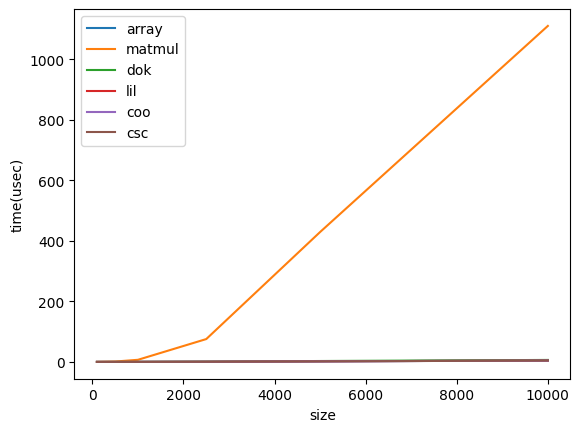

In [50]:
df.plot(x='size',y=['array','matmul','dok','lil','coo','csc'],ylabel='time(usec)')

<Axes: xlabel='size', ylabel='time(usec)'>

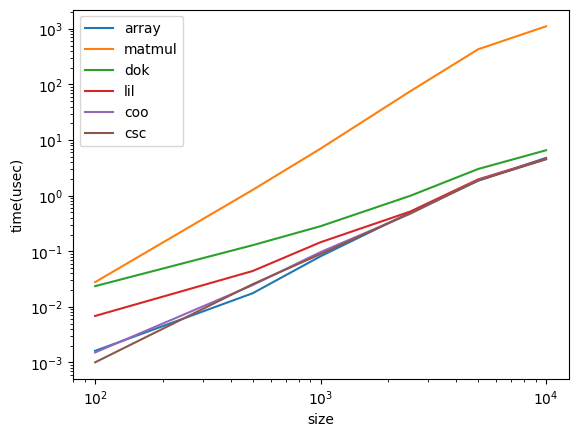

In [51]:
df.plot(x='size',y=['array','matmul','dok','lil','coo','csc'],ylabel='time(usec)',loglog=True)